### Business Objectives: 
Our main business objectives is to understand the dynamics of the labor market of Armenia using the online job portal post as a proxy. 
Business questions answering to our business objectives are defined as follows: <br><br>
1.<b>Job Nature and Company Profiles:</b> What are the types of jobs that are in demand in Armenia? How are the job natures changing over time? <br><br>
2.<b>Desired Characteristics and Skill-Sets:</b> What are the desired characteristics and skill-set of the candidates based on the job description dataset? How these are desired characteristics changing over time? <br><br>
3.<b>IT Job Classification:</b> Build a classifier that can tell us from the job description and company description whether a job is IT or not, so that this column can be automatically populated for new job postings. After doing so, understand what important factors are which drives this classification. <br><br>
4.<b>Similarity of Jobs:</b> Given a job title, find the 5 top jobs that are of a similar nature, based on the job post. 

    

### Solution Approach

1. We would pre-process the data for punctuations, numbers etc.<br>
2. Toeknaization, StopWord removal, Lemmatization would be performed suitably.<br>
3. For the IT Job classification business question, we would aim to create supervised learning classification models that are able to classify based on the job text data accurately, is it an IT job. <br>
4. On the business question of Job Nature and Company Profiles, we would use unsupervised learning techniques, such as topic modelling on time period segmented dataset. Qualitative assessment will be done on the results to help us understand the job postings.<br>
5. To understand the desired characteristics and skill-sets demanded by employers in the job ads, unsupervised learning methods such as K-means clustering will be used after appropriate dimension reduction. <br>
6. To return the top 5 most similar job posting, we would use TFIDF similarity scores that are obtained using cosine similarity scores, ranked and returned as the answer which is then evaluated individually for relevance. <br>


In [1045]:
import pandas as pd 
import numpy as np

from textblob import TextBlob
from textblob import Word

#Packages related to data visualizaiton
import seaborn as sns
import matplotlib.pyplot as plt
from wordcloud import WordCloud
%matplotlib inline

import pickle

import pandas_profiling

import string
import re

import nltk
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')
nltk.download('punkt')
from nltk.corpus import stopwords
nltk.download('stopwords')
from nltk import pos_tag
from nltk.stem.wordnet import WordNetLemmatizer 
from nltk.tokenize import word_tokenize
from nltk.corpus import wordnet

#FeatureEngineering
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer, HashingVectorizer, TfidfTransformer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.decomposition import TruncatedSVD, LatentDirichletAllocation
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.utils.validation import check_X_y, check_is_fitted
from sklearn import model_selection, preprocessing, linear_model, naive_bayes, metrics, svm, decomposition, ensemble
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import log_loss
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import train_test_split
from sklearn.cluster import KMeans
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import silhouette_score
from sklearn.cluster import MiniBatchKMeans


from xgboost import XGBClassifier

# Importing Gensim
import gensim
from gensim import corpora
from gensim.utils import lemmatize #pip install pattern
import pyLDAvis.gensim
import spacy
from spacy.matcher import Matcher

#Setting plot sizes and type of plot
plt.rc("font", size=14)
plt.rcParams['axes.grid'] = True
plt.figure(figsize=(6,3))
plt.gray()

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\Mayukh S. Mishra\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package wordnet to C:\Users\Mayukh S.
[nltk_data]     Mishra\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to C:\Users\Mayukh S.
[nltk_data]     Mishra\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to C:\Users\Mayukh S.
[nltk_data]     Mishra\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


<Figure size 432x216 with 0 Axes>

In [259]:
# read job posting data into a DataFrame
job_posts = pd.read_csv('data job posts.csv')

#### Data understanding

In [260]:
job_posts.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19001 entries, 0 to 19000
Data columns (total 24 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   jobpost           19001 non-null  object
 1   date              19001 non-null  object
 2   Title             18973 non-null  object
 3   Company           18994 non-null  object
 4   AnnouncementCode  1208 non-null   object
 5   Term              7676 non-null   object
 6   Eligibility       4930 non-null   object
 7   Audience          640 non-null    object
 8   StartDate         9675 non-null   object
 9   Duration          10798 non-null  object
 10  Location          18969 non-null  object
 11  JobDescription    15109 non-null  object
 12  JobRequirment     16479 non-null  object
 13  RequiredQual      18517 non-null  object
 14  Salary            9622 non-null   object
 15  ApplicationP      18941 non-null  object
 16  OpeningDate       18295 non-null  object
 17  Deadline    

In [261]:
job_posts.head(5)

,jobpost,date,Title,Company,AnnouncementCode,Term,Eligibility,Audience,StartDate,Duration,...,Salary,ApplicationP,OpeningDate,Deadline,Notes,AboutC,Attach,Year,Month,IT
0,AMERIA Investment Consulting Company\nJOB TITL...,"Jan 5, 2004",Chief Financial Officer,AMERIA Investment Consulting Company,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,"To apply for this position, please submit a\nc...",NaN,26 January 2004,NaN,NaN,NaN,2004,1,False
1,International Research & Exchanges Board (IREX...,"Jan 7, 2004",Full-time Community Connections Intern (paid i...,International Research & Exchanges Board (IREX),NaN,NaN,NaN,NaN,NaN,3 months,...,NaN,Please submit a cover letter and resume to:\nI...,NaN,12 January 2004,NaN,The International Research & Exchanges Board (...,NaN,2004,1,False
2,Caucasus Environmental NGO Network (CENN)\nJOB...,"Jan 7, 2004",Country Coordinator,Caucasus Environmental NGO Network (CENN),NaN,NaN,NaN,NaN,NaN,Renewable annual contract\nPOSITION,...,NaN,Please send resume or CV toursula.kazarian@......,NaN,20 January 2004\nSTART DATE: February 2004,NaN,The Caucasus Environmental NGO Network is a\nn...,NaN,2004,1,False
3,Manoff Group\nJOB TITLE: BCC Specialist\nPOSI...,"Jan 7, 2004",BCC Specialist,Manoff Group,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,Please send cover letter and resume to Amy\nPe...,NaN,23 January 2004\nSTART DATE: Immediate,NaN,NaN,NaN,2004,1,False
4,Yerevan Brandy Company\nJOB TITLE: Software D...,"Jan 10, 2004",Software Developer,Yerevan Brandy Company,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,Successful candidates should submit\n- CV; \n-...,NaN,"20 January 2004, 18:00",NaN,NaN,NaN,2004,1,True


In [262]:
job_posts.shape

(19001, 24)

In [263]:
job_posts.describe()

,Year,Month
count,19001.000000,19001.000000
mean,2010.274722,6.493869
std,3.315609,3.405503
min,2004.000000,1.000000
25%,2008.000000,3.000000
50%,2011.000000,7.000000
75%,2013.000000,9.000000
max,2015.000000,12.000000


### Exploratory analysis

In [264]:
#full report with correlation and missing charts was generating a report of size more than 250 MBs, 
#this was causing my machine to hang. Hence, generating a minimal report with varibale info and overview.

profile = pandas_profiling.ProfileReport(job_posts, minimal=True)

In [265]:
# Change the config after
#profile.set_variable("html.minify_html", False)
profile.to_file("profile_report.html")

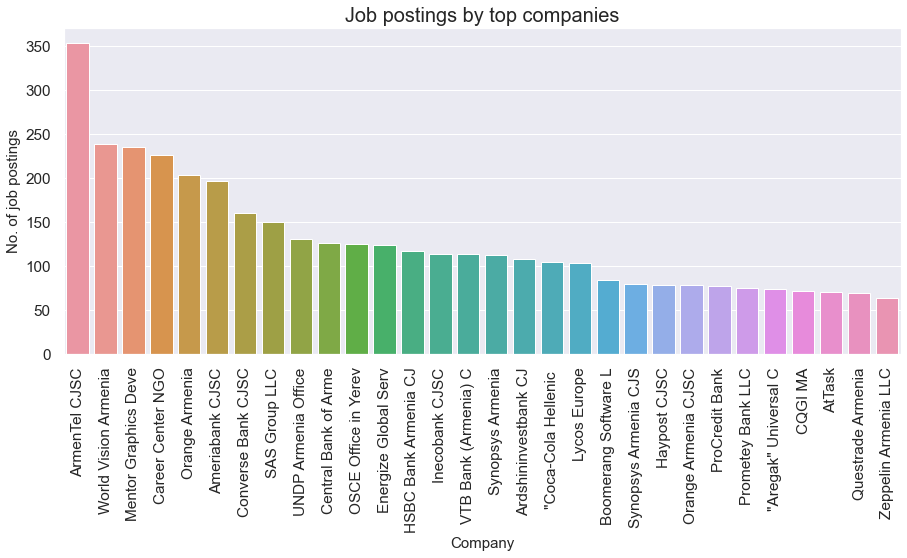

In [339]:
# Companies posting jobs

company = job_posts.groupby(job_posts['Company']).size()
company = company.sort_values(ascending = False).head(30)

#trying the truncate really long company names
company = pd.DataFrame(company)
company.reset_index( inplace = True)
company['Company'] = company['Company'].apply(lambda x: x[0: 20])
post_counts = company.iloc[:,1]

fig, axs = plt.subplots(figsize = (15,6))
sns.barplot(company['Company'], post_counts)

plt.title('Job postings by top companies',fontsize=20)
plt.xlabel('Company',fontsize=15)
plt.ylabel('No. of job postings',fontsize=15)
plt.xticks(rotation=90)
plt.show()

In [267]:
post_year = job_posts.groupby(job_posts['Year']).size()
post_year.values

array([ 875, 1138, 1116, 1538, 1785, 1191, 1511, 1697, 2149, 2009, 1983,
       2009], dtype=int64)

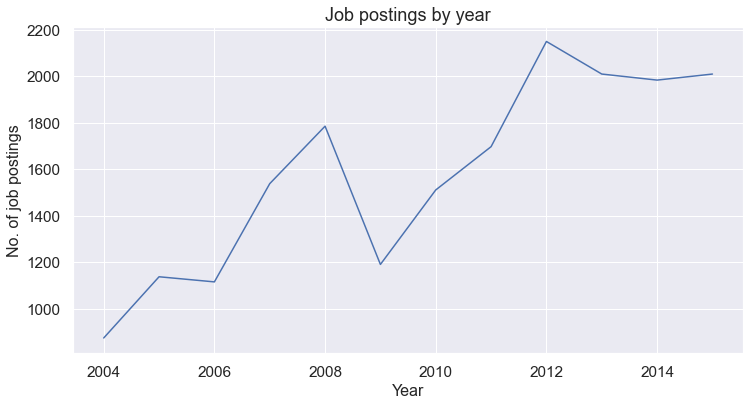

In [268]:
# job postings by year

post_year = job_posts.groupby(job_posts['Year']).size()
plt.figure(figsize=(12,6))
#sns.set_style("ticks", {"xtick.major.size":2,"ytick.major.size":2})
sns.lineplot(post_year.index, post_year.values,markers=True)
plt.title('Job postings by year', fontsize=18)
plt.ylabel('No. of job postings', fontsize=16)
plt.xlabel('Year', fontsize=16)
plt.show()

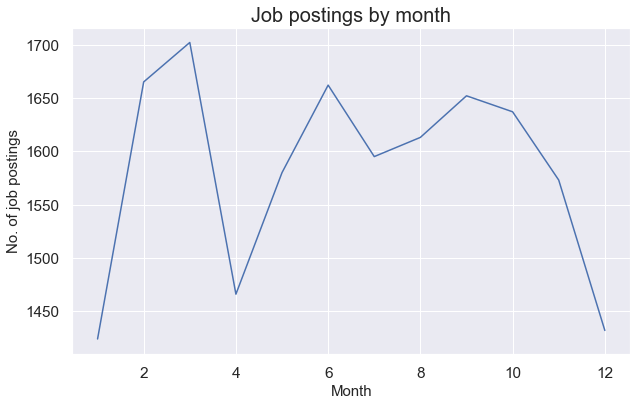

In [269]:
# job postings by month

post_month = job_posts.groupby(job_posts['Month']).size()

fig, axs = plt.subplots(figsize = (10,6))
#sns.barplot(post_month.index, post_month.values,  orient='v')
sns.lineplot(post_month.index, post_month.values,markers=True)
plt.title('Job postings by month',fontsize=20)
plt.xlabel('Month',fontsize=15)
plt.ylabel('No. of job postings',fontsize=15)
plt.show()

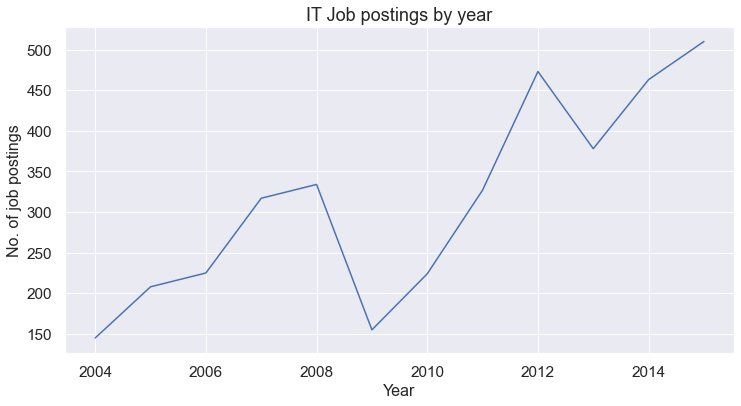

In [270]:
# IT job postings by year
it_jobs = job_posts[job_posts['IT'] == True]

post_year = it_jobs.groupby(it_jobs['Year']).size()
plt.figure(figsize=(12,6))
#sns.set_style("ticks", {"xtick.major.size":2,"ytick.major.size":2})
sns.lineplot(post_year.index, post_year.values,markers=True)
plt.title('IT Job postings by year', fontsize=18)
plt.ylabel('No. of job postings', fontsize=16)
plt.xlabel('Year', fontsize=16)
plt.show()

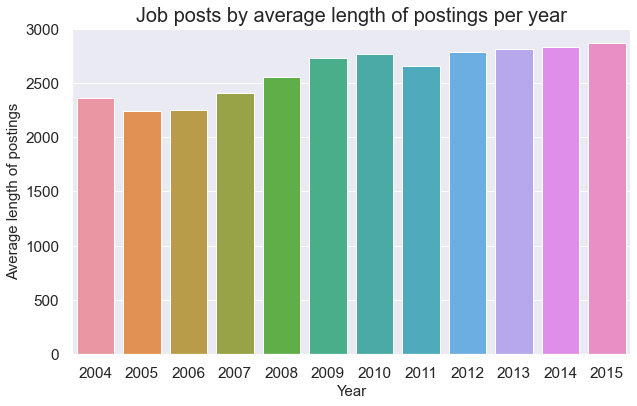

In [271]:
#job posts by average length of posting per year

jobpost_len = job_posts[['jobpost','Year']].copy()
jobpost_len['length'] = jobpost_len['jobpost'].apply(lambda x: len(str(x)))

temp_df = jobpost_len.groupby('Year')['length'].mean()

fig, axs = plt.subplots(figsize = (10,6))
sns.barplot(temp_df.index, temp_df.values,  orient='v')

plt.title('Job posts by average length of postings per year',fontsize=20)
plt.xlabel('Year',fontsize=15)
plt.ylabel('Average length of postings',fontsize=15)
plt.show()

### Data preperation/processing

In [272]:
job_data = job_posts.copy()

In [273]:
## check for duplicate rows
print("Number of duplicate rows :" , len(job_posts[job_posts.duplicated(keep=False)]))

Number of duplicate rows : 78


In [274]:
## drop duplicate row:
job_posts.drop_duplicates(keep='first',inplace=True) 

Following are available in the JOBPOST.<br>
Title	
Company    
Location    
JobDescription  
JobRequirment   
RequiredQual	 
ApplicationP    
Deadline  
AboutC 


In [342]:
#Word count in each comment:
job_data['count_word']=job_data["jobpost"].apply(lambda x: len(str(x).split()))

#Unique word count
job_data['count_unique_word']=job_data["jobpost"].apply(lambda x: len(set(str(x).split())))

job_data.head(5)

,jobpost,date,Title,Company,AnnouncementCode,Term,Eligibility,Audience,StartDate,Duration,...,OpeningDate,Deadline,Notes,AboutC,Attach,Year,Month,IT,count_word,count_unique_word
0,AMERIA Investment Consulting Company\nJOB TITL...,"Jan 5, 2004",Chief Financial Officer,AMERIA Investment Consulting Company,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,26 January 2004,NaN,NaN,NaN,2004,1,False,840,459
1,International Research & Exchanges Board (IREX...,"Jan 7, 2004",Full-time Community Connections Intern (paid i...,International Research & Exchanges Board (IREX),NaN,NaN,NaN,NaN,NaN,3 months,...,NaN,12 January 2004,NaN,The International Research & Exchanges Board (...,NaN,2004,1,False,368,235
2,Caucasus Environmental NGO Network (CENN)\nJOB...,"Jan 7, 2004",Country Coordinator,Caucasus Environmental NGO Network (CENN),NaN,NaN,NaN,NaN,NaN,Renewable annual contract\nPOSITION,...,NaN,20 January 2004\nSTART DATE: February 2004,NaN,The Caucasus Environmental NGO Network is a\nn...,NaN,2004,1,False,301,200
3,Manoff Group\nJOB TITLE: BCC Specialist\nPOSI...,"Jan 7, 2004",BCC Specialist,Manoff Group,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,23 January 2004\nSTART DATE: Immediate,NaN,NaN,NaN,2004,1,False,591,326
4,Yerevan Brandy Company\nJOB TITLE: Software D...,"Jan 10, 2004",Software Developer,Yerevan Brandy Company,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,"20 January 2004, 18:00",NaN,NaN,NaN,2004,1,True,204,159


In [343]:
print("Total word count in the corpus: ", job_data['count_word'].sum())
print("Total unique word count in the corpus: ", job_data['count_unique_word'].sum())

Total word count in the corpus:  7142593
Total unique word count in the corpus:  4519313


#### We would remove the following text from job posts as it is not usefull for our analysis
"To place a free posting for job or other career related opportunities in
your organization at careercenter.am website, e-mail us atmailbox"

In [344]:
str_to_remove = "To place a free posting for job or other career related opportunities in your organization at careercenter.am website, e-mail us atmailbox"

job_data['jobpost'] = job_data["jobpost"].apply(lambda x: str(x).replace(str_to_remove,''))

### we would need the following columns for our analysis
jobpost           
Title    
JobDescription   
JobRequirment   
RequiredQual      
ApplicationP      
AboutC  
IT  
Year

In [345]:
job_data = job_data[['jobpost','Title','JobDescription','JobRequirment','RequiredQual','ApplicationP','AboutC','IT','Year']]

In [346]:
## check for duplicate rows
print("Number of duplicate rows :" , len(job_posts[job_posts.duplicated(keep=False)]))

Number of duplicate rows : 0


In [350]:
job_data.shape

(19001, 9)

In [348]:
# Convert job post to list
jobpost_list = job_data.jobpost.values.tolist()

### Getting all human names

In [354]:
nlp = spacy.load('en')
ents_list = []
for index, row in enumerate(jobpost_list):
    doc = nlp(row)
    # Iterate over the predicted entities
    for ent in doc.ents:
        tmp = []
        if ent.label_ == 'PERSON' and (ent.text).lower() != 'java':
            tmp.append(ent.text)
    ents_list.append(tmp)
    
flat_list = []
for sublist in ents_list:
    for item in sublist:
        flat_list.append(item.lower())
person_name_set = set(flat_list)

In [356]:
def clean_text(doc_list):

    # remove web addresses
    doc_list = [re.sub('(www\.[^\s]+)|(https?://[^\s]+)','', post) for post in doc_list]

    # Remove Emails
    doc_list = [re.sub('\S*@\S*\s?', '', post) for post in doc_list]

    #remove numbers (this would take care of telephones too)
    doc_list = [re.sub(r'\d+', '', post) for post in doc_list]

    # Remove new line characters
    doc_list = [re.sub('\s+', ' ', post) for post in doc_list]

    #remove special characters
    doc_list = [re.sub("[-()\"#/@;&:{}`+=~|.!?,'0-9]", "", post) for post in doc_list]

    #remove continuos spaces with one space character
    doc_list = [re.sub(' +', ' ', post) for post in doc_list]
    
    # to lower case
    doc_list = [post.lower() for post in doc_list]
    
    return doc_list


In [357]:
jobpost_list = clean_text(jobpost_list)
print(jobpost_list[1:2])

['international research exchanges board irex title fulltime community connections intern paid internship duration months location irex armenia main office yerevan armenia description irex currently seeks to fill the position of a paid intern for the community connections cc program the position is based in the yerevan office however applicants must be willing to travel throughout armenia as necessary this position reports directly to the cc program manager responsibilities presenting the cc program to interested parties assisting in planning and scheduling of programmatic meetings and events this includes coordinating logistics for cc staff visitors and participants assisting the program staff translationinterpretation from armenian to english and vice versa helping create maintain and update the cc filing system and databases completing general administrative tasks for the cc program within the office other duties as assigned needed required qualifications bachelors degree masters is

### Tokenize and remove StopWords using gensim’s simple_preprocess()

#### We would use gensium's stopword list but following are some of the words that are frequent but do not affect are analysis.
'title','duration','location','description','responsibilities','required','qualifications','remuneration','application','procedures','application','deadline','about','company','deadline','start','date','job','position'
We would create a new list of stopwords with the above and include the gensium's list of stop words

In [804]:
#creating a list of custom stop words
custom_stopwords = ['title','duration','location','description','responsibilities','required','qualifications',
                    'remuneration','application','procedures','deadline','about','company', 'armenia', 'armenian',
                    'start','date','job','position', 'mention', 'follow', 'work', 'skill', 'post', 'ability','clearly','thanks','free','provide','letter','ensure','good','time', 'place',
           'center', 'activity', 'career', 'course', 'learn', 'activity', 'candidate', 'include', 'armenian', 'knowledge', 'experience', 
            'medium', 'opportunity', 'office', 'implementation', 'careerrelated', 'email', 'available', 'prepare', 'cjsc','announcement' ,   
            'excellent' ,'opening', 'food', 'child',  'link', 'interested', 'maintain', 'national', 'year' ,'website']

gensium_stopwords = gensim.parsing.preprocessing.STOPWORDS

new_stopwords = gensium_stopwords.union(set(custom_stopwords))


In [365]:
#tokenizing data and removing stop words
def tokenize_data(post_doc):
    finalized_list = []
    for tmp_post in post_doc:
        tmp_list = []
        for token in gensim.utils.simple_preprocess(str(tmp_post), deacc=True):
            #using the custom stopword list
            #also, anything with 2 or less characters would be removed - is not meaningful
            #person names would be removed
            if token not in new_stopwords and len(token) > 2 and token not in person_name_set:
                tmp_list.append(token)
        finalized_list.append(tmp_list)
    return finalized_list

In [366]:
jobpost_list = tokenize_data(jobpost_list)
print(jobpost_list[:1])

[['ameria', 'investment', 'consult', 'chief', 'financial', 'officer', 'ameria', 'investment', 'consult', 'seek', 'chief', 'financial', 'officer', 'manages', 'fiscal', 'administrative', 'function', 'provide', 'highly', 'responsible', 'technically', 'complex', 'staff', 'assistance', 'executive', 'director', 'work', 'perform', 'require', 'high', 'level', 'technical', 'proficiency', 'financial', 'management', 'investment', 'management', 'management', 'supervisory', 'administrative', 'skill', 'supervises', 'financial', 'management', 'administrative', 'staff', 'include', 'assign', 'review', 'employee', 'work', 'process', 'product', 'counsel', 'employee', 'performance', 'evaluation', 'recommend', 'disciplinary', 'action', 'serf', 'member', 'management', 'team', 'participate', 'strategic', 'operational', 'planning', 'directs', 'oversees', 'financial', 'management', 'activity', 'include', 'establish', 'monitoring', 'internal', 'control', 'manage', 'cash', 'investment', 'manage', 'investment', '

### Lemmatization with NLTK

In [367]:
#Map POS tag to first character lemmatize() accepts
def get_wordnet_pos(word):
    tag = nltk.pos_tag([word])[0][1][0].upper()
    tag_dict = {"J": wordnet.ADJ,
                "UH": wordnet.NOUN,
                "V": wordnet.VERB,
                "R": wordnet.ADV}

    return tag_dict.get(tag, wordnet.NOUN)

In [368]:
#lemmatize all tokens
def lemmatize_docs(post_doc):
    #get wordnet lemmatizer
    wordnet_lemmatizer = WordNetLemmatizer()
    for index_i, elem in enumerate(post_doc):
        tmp = []
        for index_j, word in enumerate(elem): 
            t = wordnet_lemmatizer.lemmatize(word, get_wordnet_pos(word))
            if len(t) > 2:
                tmp.append(t)
        #set the lemmatized words back into the tokenized list
        post_doc[index_i] = tmp
        
    return post_doc


In [369]:
jobpost_list = lemmatize_docs(jobpost_list)

## set it back into dataframe frame as clean and tokenized
flatlist = [" ".join(x) for x in jobpost_list]
job_data['clean_job_post'] = flatlist
job_data.head(5)

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


,jobpost,Title,JobDescription,JobRequirment,RequiredQual,ApplicationP,AboutC,IT,Year,clean_job_post
0,AMERIA Investment Consulting Company\nJOB TITL...,Chief Financial Officer,AMERIA Investment Consulting Company is seekin...,- Supervises financial management and administ...,"To perform this job successfully, an\nindividu...","To apply for this position, please submit a\nc...",NaN,False,2004,ameria investment consult chief financial offi...
1,International Research & Exchanges Board (IREX...,Full-time Community Connections Intern (paid i...,NaN,NaN,- Bachelor's Degree; Master's is preferred;\n-...,Please submit a cover letter and resume to:\nI...,The International Research & Exchanges Board (...,False,2004,international research exchange board irex ful...
2,Caucasus Environmental NGO Network (CENN)\nJOB...,Country Coordinator,Public outreach and strengthening of a growing...,- Working with the Country Director to provide...,"- Degree in environmentally related field, or ...",Please send resume or CV toursula.kazarian@......,The Caucasus Environmental NGO Network is a\nn...,False,2004,caucasus environmental network cenn country co...
3,Manoff Group\nJOB TITLE: BCC Specialist\nPOSI...,BCC Specialist,The LEAD (Local Enhancement and Development fo...,- Identify gaps in knowledge and overseeing in...,"- Advanced degree in public health, social sci...",Please send cover letter and resume to Amy\nPe...,NaN,False,2004,manoff group specialist manila philippine lead...
4,Yerevan Brandy Company\nJOB TITLE: Software D...,Software Developer,NaN,- Rendering technical assistance to Database M...,- University degree; economical background is ...,Successful candidates should submit\n- CV; \n-...,NaN,True,2004,brandy software developer render technical ass...


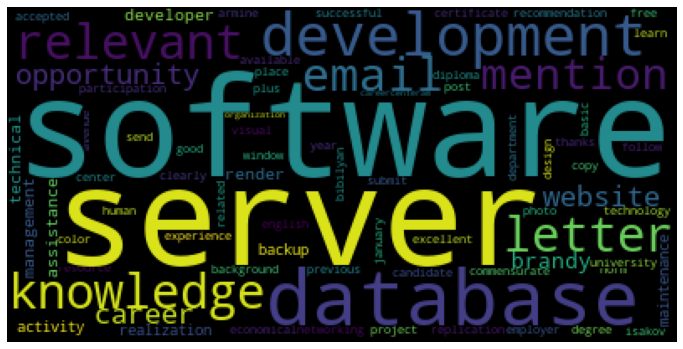

In [370]:
#word cloud expecting software developer context
wordcloud = WordCloud().generate(' '.join(jobpost_list[4]))
# plot the WordCloud image                        
plt.figure(figsize = (12, 12), facecolor = None) 
plt.imshow(wordcloud) 
plt.axis("off")  
plt.show()

## IT job clasification

#### Split the data into train & Test

In [382]:
# split the new DataFrame into training and testing sets
y = job_data['IT']
X = jobpost_list.copy()
train_X, test_X, train_y, test_y = train_test_split(X, y, random_state=1)
print(len(train_X))
print(len(test_X))
print(train_y.shape)
print(test_y.shape)

14250
4751
(14250,)
(4751,)


#### Vectorization (tfidf) for both train & test


In [383]:
#flattening the array, needed to get it proccessed by TfidfVectorizer
corpusTrainX = [" ".join(x) for x in train_X]
corpusTestX = [" ".join(x) for x in test_X]

count_vect = CountVectorizer(analyzer='word', 
                             token_pattern=r'\w{1,}', 
                             ngram_range=(1, 1 ), 
                             min_df=5, 
                             lowercase = True,
                             encoding='latin-1' , 
                             max_features=1000)
train_X_count = count_vect.fit_transform(corpusTrainX)

tfidf_vect = TfidfVectorizer(analyzer='word', 
                             token_pattern=r'\w{1,}', 
                             ngram_range=(1, 1 ), 
                             min_df=5, 
                             encoding='latin-1', 
                             max_features=1000)
train_X_tfidf = tfidf_vect.fit_transform(corpusTrainX)

#Test
test_X_count = tfidf_vect.transform(corpusTestX)
test_X_tfidf = tfidf_vect.transform(corpusTestX)

In [384]:
#Get TF-IDF matrix
#convert word count 2D array to dataframe
train_tfidf = pd.DataFrame(train_X_tfidf.toarray(), columns=tfidf_vect.get_feature_names())

train_tfidf.shape

(14250, 1000)

#### Naive Bayes classification

In [385]:
# building naive bayes model on TF-IDF
nb_model = naive_bayes.BernoulliNB ()
nb_model.fit(train_X_tfidf,train_y)

BernoulliNB(alpha=1.0, binarize=0.0, class_prior=None, fit_prior=True)

In [386]:
predict_train = nb_model.predict(train_X_tfidf)
predict_test = nb_model.predict(test_X_tfidf)

In [387]:
print('Accuracy on train: ',metrics.accuracy_score(train_y,predict_train))
print('Accuracy on test: ',metrics.accuracy_score(test_y,predict_test))

Accuracy on train:  0.8866666666666667
Accuracy on test:  0.8789728478215113


In [388]:
# predict probabilities on train and test
predict_prob_train = nb_model.predict_proba(train_X_tfidf)[:,1]
predict_prob_test = nb_model.predict_proba(test_X_tfidf)[:,1]

In [389]:
print('ROC_AUC score on train: ',metrics.roc_auc_score(train_y,predict_prob_train))
print('ROC_AUC score on test: ',metrics.roc_auc_score(test_y,predict_prob_test))

ROC_AUC score on train:  0.9291959157665196
ROC_AUC score on test:  0.9270454938591939


In [390]:
# building naive bayes model on TF-IDF
nb_model = naive_bayes.BernoulliNB ()
nb_model.fit(train_X_count,train_y)

BernoulliNB(alpha=1.0, binarize=0.0, class_prior=None, fit_prior=True)

In [391]:
predict_train = nb_model.predict(train_X_count)
predict_test = nb_model.predict(test_X_count)

In [392]:
print('Accuracy on train: ',metrics.accuracy_score(train_y,predict_train))
print('Accuracy on test: ',metrics.accuracy_score(test_y,predict_test))

Accuracy on train:  0.8866666666666667
Accuracy on test:  0.8789728478215113


In [393]:
# predict probabilities on train and test
predict_prob_train = nb_model.predict_proba(train_X_count)[:,1]
predict_prob_test = nb_model.predict_proba(test_X_count)[:,1]

In [394]:
print('ROC_AUC score on train: ',metrics.roc_auc_score(train_y,predict_prob_train))
print('ROC_AUC score on test: ',metrics.roc_auc_score(test_y,predict_prob_test))

ROC_AUC score on train:  0.9291959157665196
ROC_AUC score on test:  0.9270454938591939


### XGBoost Classifier

In [395]:
xgb_estimator = XGBClassifier( learning_rate=0.01,
                               n_estimators=1000,
                               max_depth=5,
                               min_child_weight=1,
                               gamma=1,
                               subsample=0.8,
                               colsample_bytree=0.8,
                               n_jobs=-1,
                               reg_alpa=1,
                               scale_pos_weight=1,
                               random_state=42,
                               verbose=1)

In [396]:
xgb_estimator.fit(train_X_tfidf,train_y)

[23:08:41] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.1.0\src\learner.cc:480: 
Parameters: { reg_alpa, verbose } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.8, gamma=1, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.01, max_delta_step=0, max_depth=5,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=1000, n_jobs=-1, num_parallel_tree=1,
              objective='binary:logistic', random_state=42, reg_alpa=1,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=0.8,
              tree_method='exact', validate_parameters=1, verbose=1,
              verbosity=None)

In [397]:
predict_train = xgb_estimator.predict(train_X_tfidf)
predict_test = xgb_estimator.predict(test_X_tfidf)

In [398]:
print('Accuracy on train: ',metrics.accuracy_score(train_y,predict_train))
print('Accuracy on test: ',metrics.accuracy_score(test_y,predict_test))

Accuracy on train:  0.9774736842105263
Accuracy on test:  0.9572721532308988


In [399]:
# predict probabilities on train and test
predict_prob_train = xgb_estimator.predict_proba(train_X_tfidf)[:,1]
predict_prob_test = xgb_estimator.predict_proba(test_X_tfidf)[:,1]

In [400]:
print('ROC_AUC score on train: ',metrics.roc_auc_score(train_y,predict_prob_train))
print('ROC_AUC score on test: ',metrics.roc_auc_score(test_y,predict_prob_test))

ROC_AUC score on train:  0.9973240433307635
ROC_AUC score on test:  0.985168806359664


Confusion Matix:
 [[3790   64]
 [ 139  758]]


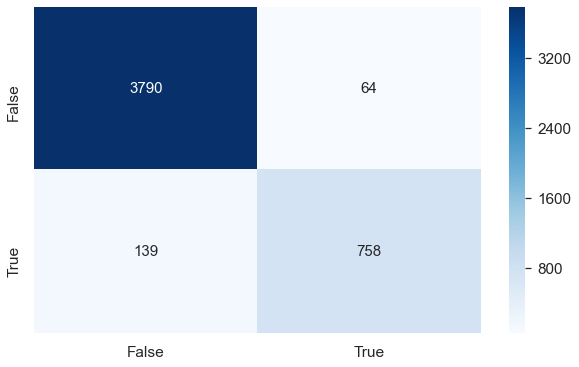

In [401]:
print('Confusion Matix:''\n', metrics.confusion_matrix(test_y, predict_test))
cf_matrix = metrics.confusion_matrix(test_y, predict_test)
categories = ['False', 'True']
plt.figure(figsize=(10,6))
sns.set(font_scale=1.4)
sns.heatmap(cf_matrix, annot=True, annot_kws={"size":15}, cmap='Blues', fmt='g', xticklabels=categories,  yticklabels=categories)
plt.show()

In [402]:
def plot_roc_curve(fpr, tpr, label=None, auc=None):
    auc_str = 'ROC Curve - Arean under the curve - ' + str(auc)
    plt.figure(figsize=(10,6))
    plt.title(auc_str)
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.axis([-0.005, 1, 0, 1.005])
    plt.xticks(np.arange(0,1, 0.05), rotation=90)
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate (Recall)")
    plt.legend(loc='best')

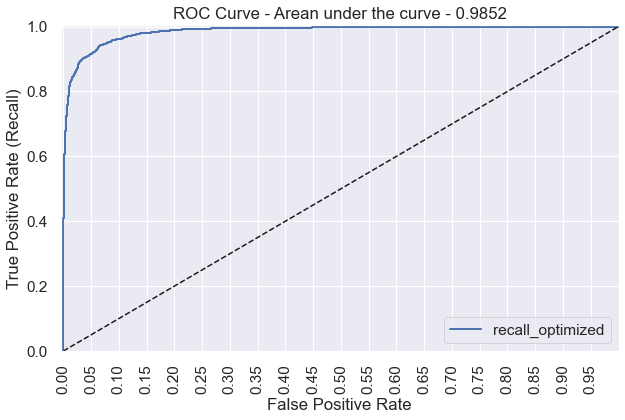

In [403]:
#Plot ROC AUC curve
auc_score = metrics.roc_auc_score(test_y,predict_prob_test)
fpr, tpr, auc_thresholds = roc_curve(test_y,predict_prob_test)
plot_roc_curve(fpr, tpr, 'recall_optimized', round(auc_score,4))

In [404]:
# WITH DTM
xgb_estimator.fit(train_X_count,train_y)

[23:15:20] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.1.0\src\learner.cc:480: 
Parameters: { reg_alpa, verbose } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.8, gamma=1, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.01, max_delta_step=0, max_depth=5,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=1000, n_jobs=-1, num_parallel_tree=1,
              objective='binary:logistic', random_state=42, reg_alpa=1,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=0.8,
              tree_method='exact', validate_parameters=1, verbose=1,
              verbosity=None)

In [405]:
predict_train = xgb_estimator.predict(train_X_count)
predict_test = xgb_estimator.predict(test_X_count)

In [406]:
print('Accuracy on train: ',metrics.accuracy_score(train_y,predict_train))
print('Accuracy on test: ',metrics.accuracy_score(test_y,predict_test))

Accuracy on train:  0.9716491228070175
Accuracy on test:  0.9206482845716691


In [407]:
# predict probabilities on train and test
predict_prob_train = xgb_estimator.predict_proba(train_X_count)[:,1]
predict_prob_test = xgb_estimator.predict_proba(test_X_count)[:,1]

In [408]:
print('ROC_AUC score on train: ',metrics.roc_auc_score(train_y,predict_prob_train))
print('ROC_AUC score on test: ',metrics.roc_auc_score(test_y,predict_prob_test))

ROC_AUC score on train:  0.9948900138117851
ROC_AUC score on test:  0.9699106576207724


Confusion Matix:
 [[3811   43]
 [ 334  563]]


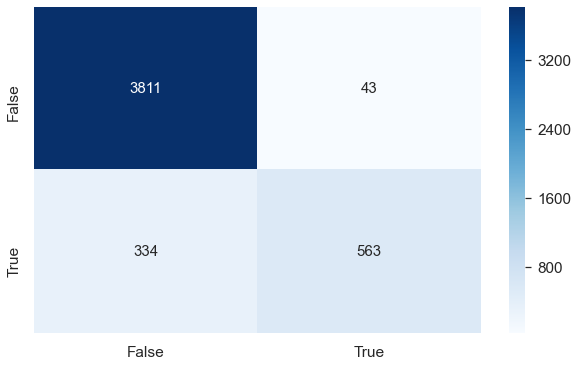

In [409]:
print('Confusion Matix:''\n', metrics.confusion_matrix(test_y, predict_test))
cf_matrix = metrics.confusion_matrix(test_y, predict_test)
categories = ['False', 'True']
plt.figure(figsize=(10,6))
sns.set(font_scale=1.4)
sns.heatmap(cf_matrix, annot=True, annot_kws={"size":15}, cmap='Blues', fmt='g', xticklabels=categories,  yticklabels=categories)
plt.show()

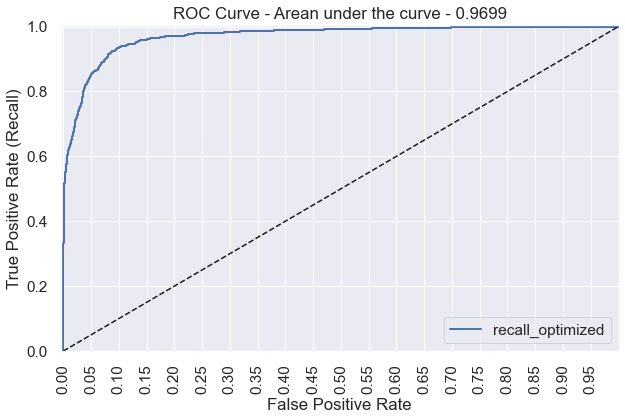

In [410]:
#Plot ROC AUC curve
auc_score = metrics.roc_auc_score(test_y,predict_prob_test)
fpr, tpr, auc_thresholds = roc_curve(test_y,predict_prob_test)
plot_roc_curve(fpr, tpr, 'recall_optimized', round(auc_score,4))

### Desired characterstics and skill sets
1. what are the desired skills and characteristics based on job description dataset?
2. How are the desired characterstics changing over time ?

For the above analysis we would use the JobRequirment data set.

In [890]:
# Convert JobRequirment to list
jobreq_list = job_data.JobRequirment.dropna().tolist()
jobreq_df = job_data[['JobRequirment','Year']].dropna()

## cleansing the text, tokenizing, removing stopwords, lemmatizing
jobreq_list = clean_text(jobreq_list)
jobreq_list = tokenize_data(jobreq_list)
jobreq_list = lemmatize_docs(jobreq_list)

In [891]:
for i, term in enumerate(jobreq_list):
    for j in jobreq_list[i]:
        if len(j) < 4:
            jobreq_list[i].remove(j)

#### Vectorization (tfidf) 

In [892]:
#flattening the array, needed to get it proccessed by TfidfVectorizer
corpusJobReq = [" ".join(x) for x in jobreq_list]
jobreq_df['JobReq_Clean'] = corpusJobReq.copy()

tfidf_vect_job_req = TfidfVectorizer(analyzer='word', 
                             token_pattern=r'\w{1,}', 
                             ngram_range=(1, 1 ), 
                             min_df=5, 
                             encoding='latin-1', 
                             max_features=2200)

job_req_tfidf = tfidf_vect_job_req.fit_transform(corpusJobReq)

In [893]:
job_req_tfidf.shape

(16479, 2200)

#### Latent Semantic analysis with TruncatedSVD

### KMeans clustering

In [894]:
km_mini_4 = MiniBatchKMeans(n_clusters=4, init_size=1024, batch_size=2048, random_state=20).fit_predict(job_req_tfidf)
km_mini_5 = MiniBatchKMeans(n_clusters=5, init_size=1024, batch_size=2048, random_state=20).fit_predict(job_req_tfidf)
km_mini_6 = MiniBatchKMeans(n_clusters=6, init_size=1024, batch_size=2048, random_state=20).fit_predict(job_req_tfidf)
km_mini_7 = MiniBatchKMeans(n_clusters=7, init_size=1024, batch_size=2048, random_state=20).fit_predict(job_req_tfidf)
km_mini_8 = MiniBatchKMeans(n_clusters=8, init_size=1024, batch_size=2048, random_state=20).fit_predict(job_req_tfidf)

In [895]:
terms = np.array(tfidf_vect_job_req.get_feature_names())
num_clusters = [4,5,6,7,8]
km_models = [km_mini_4, km_mini_5, km_mini_6, km_mini_7, km_mini_8 ]

In [896]:
def get_top_keywords(data, clusters, labels, n_terms):
    df = pd.DataFrame(data.todense()).groupby(clusters).mean()
    
    for i,r in df.iterrows():
        print('Cluster {}'.format(i))
        print(','.join([labels[t] for t in np.argsort(r)[-n_terms:]]))
    print()
            
for i, cluster in enumerate(km_models):
    print('For CLUSTERS CENTERS = {}\n'.format(i + 4))
    get_top_keywords(job_req_tfidf, cluster, tfidf_vect_job_req.get_feature_names(), 10)

For CLUSTERS CENTERS = 4

Cluster 0
company,business,develop,market,marketing,service,client,product,sale,customer
Cluster 1
support,assist,activity,perform,management,accounting,responsible,financial,report,project
Cluster 2
design,functional,manual,script,software,regression,defect,case,automate,test
Cluster 3
test,participate,develop,code,technical,development,team,application,software,design

For CLUSTERS CENTERS = 5

Cluster 0
plan,training,development,management,report,legal,program,activity,financial,project
Cluster 1
translation,correspondence,call,document,cash,perform,duty,financial,report,accounting
Cluster 2
participate,technical,application,code,develop,development,team,design,software,test
Cluster 3
business,credit,develop,market,service,marketing,client,product,sale,customer
Cluster 4
maintenance,develop,database,service,design,network,equipment,data,system,responsible

For CLUSTERS CENTERS = 6

Cluster 0
assist,correspondence,report,duty,equipment,meeting,perform,docume

In [897]:
sc_df = pd.DataFrame(columns = ['Cluster', 'SC_score'])

index = 0
for i, cluster in enumerate(km_models):
    sc_df.loc[index] = [i+4, silhouette_score(job_req_tfidf, cluster)]
    index = index + 1
    
sc_df = sc_df.sort_values(by='SC_score',ascending=False)
sc_df

,Cluster,SC_score
4,8.0,0.019941
3,7.0,0.017631
1,5.0,0.017273
2,6.0,0.017146
0,4.0,0.014771


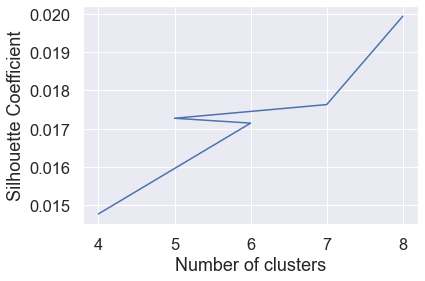

In [898]:
# plot SC scores
plt.plot(sc_df.Cluster, sc_df.SC_score)
plt.xlabel('Number of clusters')
plt.ylabel('Silhouette Coefficient')
plt.grid(True)

In [1046]:
with open('clusters.pkl', 'wb') as f:
    pickle.dump(km_mini_6, f)

#### Based on interpretability though SC score is low, we would choose Cluster solution 5

In [910]:
#clustersMini
#for i in range(7):

unique, counts = np.unique(km_mini_6, return_counts=True)
count_dict = dict(zip(unique, counts))
cluster_dist_df = pd.DataFrame(list(count_dict.items()),columns = ['Cluster_No','Count'])
cluster_dist_df

,Cluster_No,Count
0,0,4703
1,1,2183
2,2,631
3,3,2037
4,4,4832
5,5,2093


In [911]:
#assign clusters to all job requirements.
jobreq_df['Cluster'] = km_mini_6

In [912]:
#For CLUSTERS CENTERS =  6
#Cluster 0: Administration
#Cluster 1: Financial Services
#Cluster 2: IT Testing
#Cluster 3: IT development
#Cluster 4: Sales and Marketing
#Cluster 5: Banking

#assign appropriate lables to the clusters
def change_cluster_label(x):
    if x == 0:
        x = 'Administration'
    elif x == 1:
        x = 'Financial Services'
    elif x == 2:
        x = 'IT Testing'
    elif x == 3:
        x = 'IT development'
    elif x == 4:
        x = 'Sales and Marketing'
    else:
        x = 'Banking'
    return x

jobreq_df['Cluster'] = jobreq_df['Cluster'].apply(change_cluster_label)

In [913]:
jobreq_df.head(5)

,JobRequirment,Year,JobReq_Clean,Cluster,Period
0,- Supervises financial management and administ...,2004,supervises financial management administrative...,Financial Services,2004 - 2007
2,- Working with the Country Director to provide...,2004,work country director environmental informatio...,Sales and Marketing,2004 - 2007
3,- Identify gaps in knowledge and overseeing in...,2004,identify oversee information collection consol...,Sales and Marketing,2004 - 2007
4,- Rendering technical assistance to Database M...,2004,render technical assistance database managemen...,IT development,2004 - 2007
8,- Coordinating the work of subordinate employe...,2004,coordinate subordinate employee maintain liais...,Administration,2004 - 2007


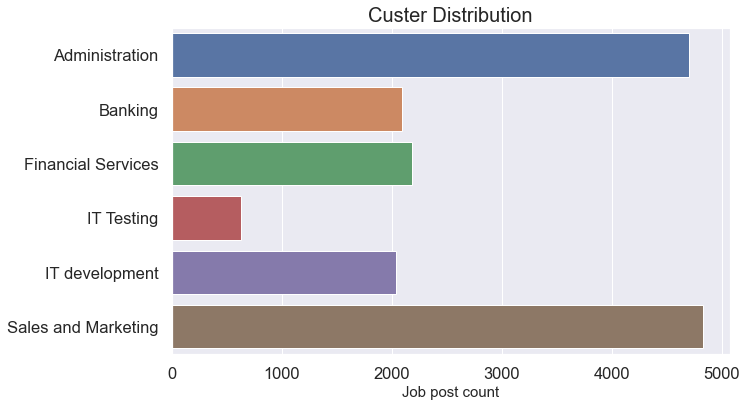

In [914]:
#plot topic frequency in the corpus
cluster_dist = jobreq_df.groupby(jobreq_df['Cluster']).size()
sns.set(font_scale=1.5)
fig, axs = plt.subplots(figsize = (10,6))
sns.barplot(cluster_dist.values, cluster_dist.index,  orient='h')

plt.title('Custer Distribution',fontsize=20)
plt.xlabel('Job post count',fontsize=15)
plt.ylabel('',fontsize=15)
#plt.xticks(rotation=90)
plt.show()

### To understand how the requirments have changed over time,      
we would group the requirments based on years and the topic model building.

In [915]:
#Split JobRequirment column based on Year
#Spitting 2004 to 2015, 12 years in 3 period of 4 years each

jobreq_df["Period"] = np.nan
for index, row in jobreq_df.iterrows():
    if row['Year'] == 2004 or row['Year'] == 2005 or row['Year'] == 2006 or row['Year'] == 2007:
        jobreq_df.loc[index, 'Period'] = '2004 - 2007'
    elif row['Year'] == 2008 or row['Year'] == 2009 or row['Year'] == 2010 or row['Year'] == 2011:
        jobreq_df.loc[index, 'Period'] = '2008 - 2011'
    else:
        jobreq_df.loc[index, 'Period'] = '2012 - 2015'

In [916]:
#aggregating over created periods.
jobreq_df_clusters = jobreq_df.groupby(['Period','Cluster']).agg({'Cluster':['count']})
jobreq_df_clusters.columns = ["_".join(x) for x in jobreq_df_clusters.columns.ravel()]
jobreq_df_clusters.reset_index(inplace = True)

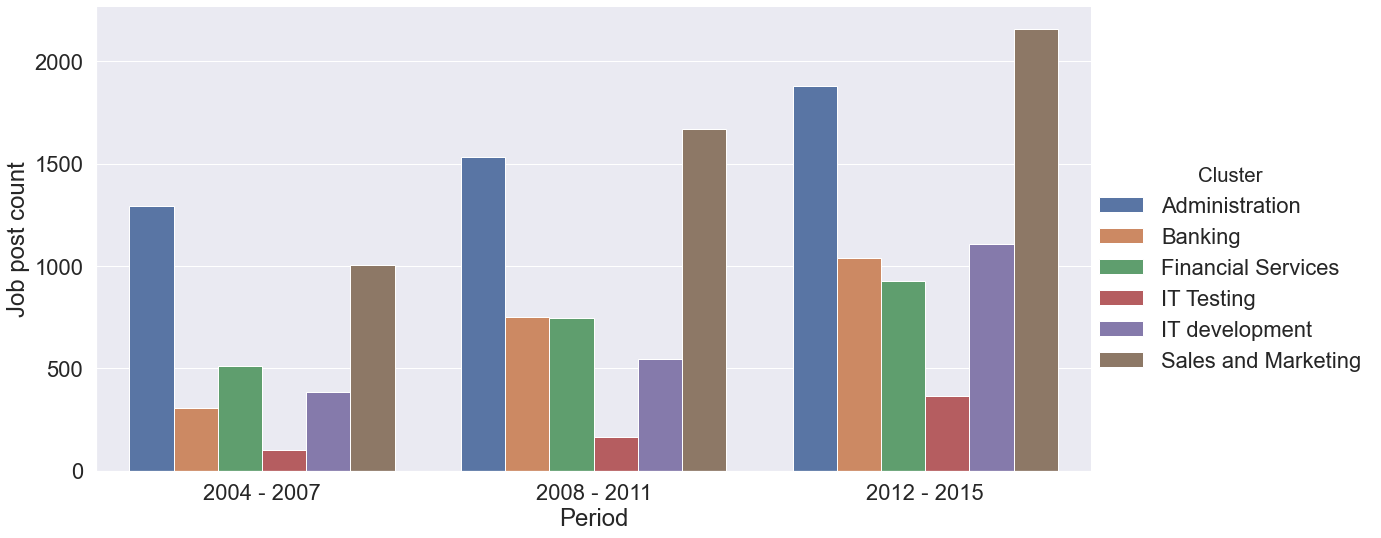

In [917]:
#fig, axs = plt.subplots(figsize = (12,6))
sns.set(font_scale=2)
g = sns.catplot(x='Period', y='Cluster_count', hue='Cluster',  data=jobreq_df_clusters, kind='bar', height=8, aspect =2)
g.set_axis_labels("Period", "Job post count");
#plt.show()

### NER with Spacy
#### To identify skills in high demand for all job postings

the "en_core_web_sm" package is a small English model that supports all core capabilities and is trained on web text. The package provides the binary weights that enable spaCy to make predictions.

In the Named Entity Recognition (NER) task, systems are required to recognize the Named Entities occurring in the text. More specifically, the task is to find Person (PER), Organization (ORG), Location (LOC) and Geo-Political Entities (GPE). For instance, in the statement ”Shyam lives in India”, NER system extracts Shyam which refers to name of the person and India which refers to name of the country.

In [871]:
def clean_text_ner(doc_list):

    #remove numbers (this would take care of telephones too)
    doc_list = [re.sub(r'\d+', '', post) for post in doc_list]

    # Remove new line characters
    doc_list = [re.sub('\s+', ' ', post) for post in doc_list]

    #remove special characters
    doc_list = [re.sub("[-()\"#/@;&:{}`+=~|.!?,'0-9]", "", post) for post in doc_list]

    return doc_list

<>:7: DeprecationWarning: invalid escape sequence \s
<>:7: DeprecationWarning: invalid escape sequence \s
<>:7: DeprecationWarning: invalid escape sequence \s
<ipython-input-871-473fab29eefc>:7: DeprecationWarning: invalid escape sequence \s
  doc_list = [re.sub('\s+', ' ', post) for post in doc_list]


#### for this analysis we would use the RequiredQual column data

In [872]:
skill_data = job_data[['RequiredQual', 'Year']]

## check for missing values
print("missing values in each columns" , skill_data.isnull().sum(), sep='\n')

missing values in each columns
RequiredQual    484
Year              0
dtype: int64


In [873]:
#drop rows with RequiredQual as NaN, ignoring the missings values
skill_data = skill_data.dropna()

# Convert RequiredQual to list
req_qual_list = skill_data.RequiredQual.tolist()


In [874]:
#tokenizing data and removing stop words
def tokenize_data_ner(post_doc):
    finalized_list = []
    for tmp_post in post_doc:
        tmp_list = []
        for token in gensim.utils.simple_preprocess(str(tmp_post), deacc=True):
            #using the custom stopword list
            #also, anything with 2 or less characters would be removed - is not meaningful
            #person names would be removed
            if token not in new_stopwords and token not in person_name_set:
                tmp_list.append(token)
        finalized_list.append(tmp_list)
    return finalized_list

In [875]:

## cleansing RequiredQual, removing the numbers, new lines and special characters
req_qual_list = clean_text_ner(req_qual_list)
skill_data['clean_req_qual'] = req_qual_list   
skill_data.head()


,RequiredQual,Year,clean_req_qual
0,"To perform this job successfully, an\nindividu...",2004,To perform this job successfully an individual...
1,- Bachelor's Degree; Master's is preferred;\n-...,2004,Bachelors Degree Masters is preferred Excell...
2,"- Degree in environmentally related field, or ...",2004,Degree in environmentally related field or ye...
3,"- Advanced degree in public health, social sci...",2004,Advanced degree in public health social scien...
4,- University degree; economical background is ...,2004,University degree economical background is a ...


In [876]:
#Identifying all ORG types in the required Qualification text
nlp = spacy.load('en')
ents_list = []
for index, row in skill_data.iterrows():
    doc = nlp(row['clean_req_qual'])
    tmp = []
    # Iterate over the predicted entities
    for ent in doc.ents:
        if ent.label_ == 'ORG':
            tmp.append(ent.text)
    ents_list.append(tmp)

In [877]:
#faltten the 2D org list to 1D
ents_flat_list = [item for sublist in ents_list for item in sublist]

In [878]:
#creating a DF and sorting in the skill set dataframe for all ORG entitiy types
skill_data1 = pd.DataFrame()
skill_data1['spacy_ents'] = ents_flat_list

#getting all terms which frequency greater than 10
vc = skill_data1['spacy_ents'].value_counts().sort_values(ascending = False)
vc = vc[vc >= 10]

In [879]:
top_50 = list(vc[:50].index)
clean_org_list = "\n".join(top_50)

#printing top 50 terms
print(top_50)

['MS Office', 'Familiarity', 'SQL', 'Microsoft Office', 'Analytical', 'Willingness', 'Microsoft', 'Computer Sciences', 'OOP', 'RA', 'Java', 'Proven', 'Fluent', 'Computer Science', 'Higher', 'JavaScript', 'CSS', 'Economics', 'XML', 'EDA', 'IFRS', 'ASPNET', 'OOD', 'UI', 'Computer', 'Adobe Photoshop', 'SQL Server', 'MS Office  Fluency', 'Flexible', 'Social Sciences', 'PHP', 'STL', 'Solid', 'Economics Finance', 'the Central Bank', 'Organizational', 'AJAX', 'Excellent', 'EU', 'AS Bank', 'Time', 'NET', 'Perl', 'Physical Design Automation', 'CBA', 'Outstanding', 'UN', 'MS Windows MS Office', 'USAID', 'TSQL']


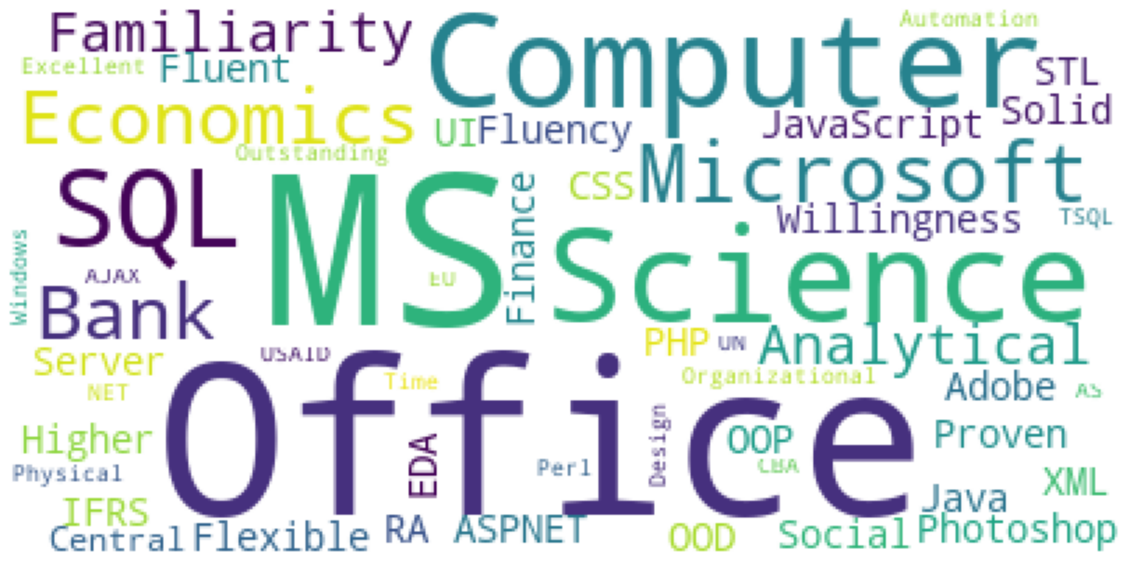

In [884]:
#word cloud expecting software developer context
wordcloud = WordCloud(background_color='white').generate(clean_org_list)
# plot the WordCloud image                        
plt.figure(figsize = (20, 20), facecolor = None) 
plt.imshow(wordcloud) 
plt.axis("off")  
plt.show()

To understand skill sets in high demand, we used the Spacy library for Named Entity Recognition on the RequiredQual column in the dataset. We focused on ‘ORG’ entity type as it contained the names of tools, software, skills etc. in the corpus over the entire period of job postings.
The results are visualized below. MS tools, computer related skills are most sought after.



### Topic modelling to anlayze and understand nature of jobs

#### we would use genism to create a LDA model for topic modelling using jobpost column

In [786]:
# Creating the object for LDA model using gensim library
Lda = gensim.models.ldamodel.LdaModel

In [787]:
dictionary = corpora.Dictionary(jobpost_list)
print(dictionary)

Dictionary(22969 unique tokens: ['able', 'acca', 'accepted', 'accounting', 'achieve']...)


In [788]:
# Converting list of documents (corpus) into Document Term Matrix using dictionary prepared above.
doc_term_matrix = [dictionary.doc2bow(doc) for doc in jobpost_list]

In [789]:
#pyLDAvis usage
corpora.MmCorpus.serialize('corpus.mm', doc_term_matrix)

In [790]:
# Running and Trainign LDA model on the document term matrix.
ldamodel_5 = Lda(doc_term_matrix, num_topics=5, id2word = dictionary,passes=1)
ldamodel_6 = Lda(doc_term_matrix, num_topics=6, id2word = dictionary,passes=1)
ldamodel_7 = Lda(doc_term_matrix, num_topics=7, id2word = dictionary,passes=1)
ldamodel_8 = Lda(doc_term_matrix, num_topics=8, id2word = dictionary,passes=1)

In [791]:
#listing out topics for each lda model
lda_list = [ldamodel_5,ldamodel_6,ldamodel_7, ldamodel_8 ]
for i, elem in enumerate(lda_list):
    topics = elem.show_topics(formatted=False, num_words=10)
    print("LDA with {} topics:".format(i+5))
    for t in range(len(topics)):
        print("Topic {}, top {} words:".format(t+1,10))
        print(" ".join([w[0] for w in topics[t][1]]))
    print()

LDA with 5 topics:
Topic 1, top 10 words:
project legal language organization english international education document field training
Topic 2, top 10 words:
accounting financial language bank english organization report finance audit form
Topic 3, top 10 words:
software development design test team developer language technical develop organization
Topic 4, top 10 words:
customer language sale organization service english russian responsible marketing communication
Topic 5, top 10 words:
project development management program support organization develop team plan community

LDA with 6 topics:
Topic 1, top 10 words:
language english organization write open communication contact information student apply
Topic 2, top 10 words:
project development support organization international community management programme training local
Topic 3, top 10 words:
software development design test team developer technical language develop organization
Topic 4, top 10 words:
project management development

In [1047]:
with open('lda_model.pkl', 'wb') as f:
    pickle.dump(ldamodel_5, f)

#### A good topic model will have non-overlapping, fairly big sized blobs for each topic. 

In [732]:
pyLDAvis.enable_notebook()

In [796]:
#d = gensim.corpora.Dictionary.load('dictionary.dict')
c = gensim.corpora.MmCorpus('corpus.mm')
#lda = gensim.models.LdaModel.load('topic.model')

In [881]:
data = pyLDAvis.gensim.prepare(ldamodel_5, c, dictionary)
data

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
3     -0.010947  0.082069       1        1  25.323292
4      0.033573 -0.102809       2        1  22.975946
2     -0.193998 -0.012053       3        1  20.162785
1      0.080836  0.098673       4        1  16.429277
0      0.090537 -0.065880       5        1  15.108699, topic_info=               Term          Freq         Total Category  logprob  loglift
3        accounting   7869.000000   7869.000000  Default  30.0000  30.0000
203        software  13285.000000  13285.000000  Default  29.0000  29.0000
341         project  25562.000000  25562.000000  Default  28.0000  28.0000
1119           sale   8731.000000   8731.000000  Default  27.0000  27.0000
550            test   9305.000000   9305.000000  Default  26.0000  26.0000
...             ...           ...           ...      ...      ...      ...
59           degree   1752.559448  10666.940430   Topic5  -5.4311   0.0838
111     information   1839.607178  13956.855469   Topic5  -5.3826  -0.1365
179         related   1668.125244  11373.686523   Topic5  -5.4805  -0.0297
40    communication   1687.834351  14905.775391   Topic5  -5.4687  -0.2884
430         service   1676.725708  15940.597656   Topic5  -5.4753  -0.3621

[503 rows x 6 columns], token_table=       Topic      Freq      Term
term                            
15352      2  0.978290    aarhus
15352      5  0.010298    aarhus
1          1  0.043430      acca
1          2  0.004136      acca
1          4  0.951315      acca
...      ...       ...       ...
237        4  0.161164     write
237        5  0.160389     write
13534      4  0.993082   yearend
9842       1  0.994401  zeppelin
9842       4  0.003501  zeppelin

[1460 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[4, 5, 3, 2, 1])

### looking at the topic top words i.e interpretablity and the pyLDAvis output where    
#### we have fairly even sized blobs and very little overlap, we would select 5 topic solution  

Topic 1: Education    
Topic 2: Banking and Finance    
Topic 3: Information Technology      
Topic 4: Sales and Marketing     
Topic 5: Management   


In [882]:
print(ldamodel_5.print_topics(num_topics=5, num_words=10))

[(0, '0.012*"project" + 0.012*"legal" + 0.011*"language" + 0.011*"organization" + 0.009*"english" + 0.008*"international" + 0.008*"education" + 0.006*"document" + 0.006*"field" + 0.005*"training"'), (1, '0.017*"accounting" + 0.016*"financial" + 0.013*"language" + 0.012*"bank" + 0.012*"english" + 0.012*"organization" + 0.010*"report" + 0.007*"finance" + 0.006*"audit" + 0.006*"form"'), (2, '0.020*"software" + 0.020*"development" + 0.017*"design" + 0.015*"test" + 0.014*"team" + 0.010*"developer" + 0.010*"language" + 0.009*"technical" + 0.009*"develop" + 0.008*"organization"'), (3, '0.014*"customer" + 0.014*"language" + 0.013*"sale" + 0.011*"organization" + 0.011*"service" + 0.010*"english" + 0.010*"russian" + 0.009*"responsible" + 0.009*"marketing" + 0.008*"communication"'), (4, '0.026*"project" + 0.017*"development" + 0.014*"management" + 0.010*"program" + 0.009*"support" + 0.009*"organization" + 0.006*"develop" + 0.006*"team" + 0.006*"plan" + 0.006*"community"')]


In [805]:
def dominant_topic(ldamodel, corpus, texts):
    #Function to find the dominant topic in each review
    topics_df = pd.DataFrame() 
    # Get main topic in each review
    for i, row in enumerate(ldamodel[corpus]):
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each review
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # =&gt; dominant topic
                wp = ldamodel.show_topic(topic_num,topn=10)
                topic_keywords = ", ".join([word for word, prop in wp])
                topics_df = topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']
    contents = pd.Series(texts)
    topics_df = pd.concat([topics_df, contents], axis=1)
    return(topics_df)

In [806]:
df_dominant_topic = dominant_topic(ldamodel=ldamodel_5, corpus=doc_term_matrix, texts=job_data['jobpost']) 
df_dominant_topic.head()

,Dominant_Topic,Perc_Contribution,Topic_Keywords,jobpost
0,1.0,0.4883,"accounting, financial, language, bank, english...",AMERIA Investment Consulting Company\nJOB TITL...
1,0.0,0.6635,"project, legal, language, organization, englis...",International Research & Exchanges Board (IREX...
2,4.0,0.8738,"project, development, management, program, sup...",Caucasus Environmental NGO Network (CENN)\nJOB...
3,4.0,0.9875,"project, development, management, program, sup...",Manoff Group\nJOB TITLE: BCC Specialist\nPOSI...
4,2.0,0.5101,"software, development, design, test, team, dev...",Yerevan Brandy Company\nJOB TITLE: Software D...


### Review topics distribution across documents

In [809]:
#Topic 1: Education
#Topic 2: Banking and Finance
#Topic 3: Information Technology
#Topic 4: Sales and Marketing
#Topic 5: Management

#assign appropriate lables to the clusters
def change_cluster_label(x):
    if x == 0:
        x = 'Education'
    elif x == 1:
        x = 'Banking and Finance'
    elif x == 2:
        x = 'Information Technology'
    elif x == 3:
        x = 'Sales and Marketing'
    else:
        x = 'Management'
    return x

df_dominant_topic['Dominant_Topic_Name'] = np.nan
df_dominant_topic['Dominant_Topic_Name'] = df_dominant_topic['Dominant_Topic'].apply(change_cluster_label)

In [812]:
df_dominant_topic['Dominant_Topic'].value_counts()

3.0    6585
2.0    4557
1.0    3165
4.0    2377
0.0    2317
Name: Dominant_Topic, dtype: int64

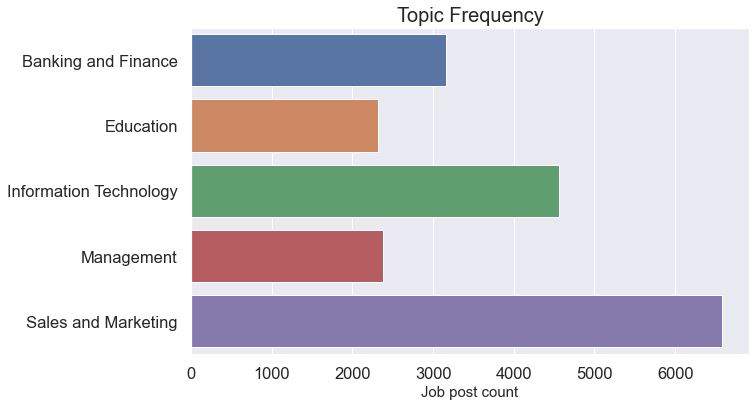

In [813]:
#plot topic frequency in the corpus
topic_dist = df_dominant_topic.groupby(df_dominant_topic['Dominant_Topic_Name']).size()
sns.set(font_scale=1.5)
fig, axs = plt.subplots(figsize = (10,6))
sns.barplot(topic_dist.values, topic_dist.index,  orient='h')

plt.title('Topic Frequency',fontsize=20)
plt.xlabel('Job post count',fontsize=15)
plt.ylabel('',fontsize=15)
#plt.xticks(rotation=90)
plt.show()

### To understand how the job nature has changed over time,      
we would group the requirements based on years and the topic model building.

In [814]:
#filtering topic dataframe based on Year
#Spitting 2004 to 2015, 12 years in 3 period of 4 years each

df_dominant_topic["Period"] = np.nan
df_dominant_topic["Year"] = job_data['Year'].copy()
for index, row in df_dominant_topic.iterrows():
    if row['Year'] == 2004 or row['Year'] == 2005 or row['Year'] == 2006 or row['Year'] == 2007:
        df_dominant_topic.loc[index, 'Period'] = '2004 - 2007'
    elif row['Year'] == 2008 or row['Year'] == 2009 or row['Year'] == 2010 or row['Year'] == 2011:
        df_dominant_topic.loc[index, 'Period'] = '2008 - 2011'
    else:
        df_dominant_topic.loc[index, 'Period'] = '2012 - 2015'

In [816]:
#aggregating over created periods.
topic_years = df_dominant_topic.groupby(['Period','Dominant_Topic_Name']).agg({'Dominant_Topic_Name':['count']})
topic_years.columns = ["_".join(x) for x in topic_years.columns.ravel()]
topic_years.reset_index(inplace = True)
topic_years.head()

,Period,Dominant_Topic_Name,Dominant_Topic_Name_count
0,2004 - 2007,Banking and Finance,814
1,2004 - 2007,Education,794
2,2004 - 2007,Information Technology,997
3,2004 - 2007,Management,670
4,2004 - 2007,Sales and Marketing,1392


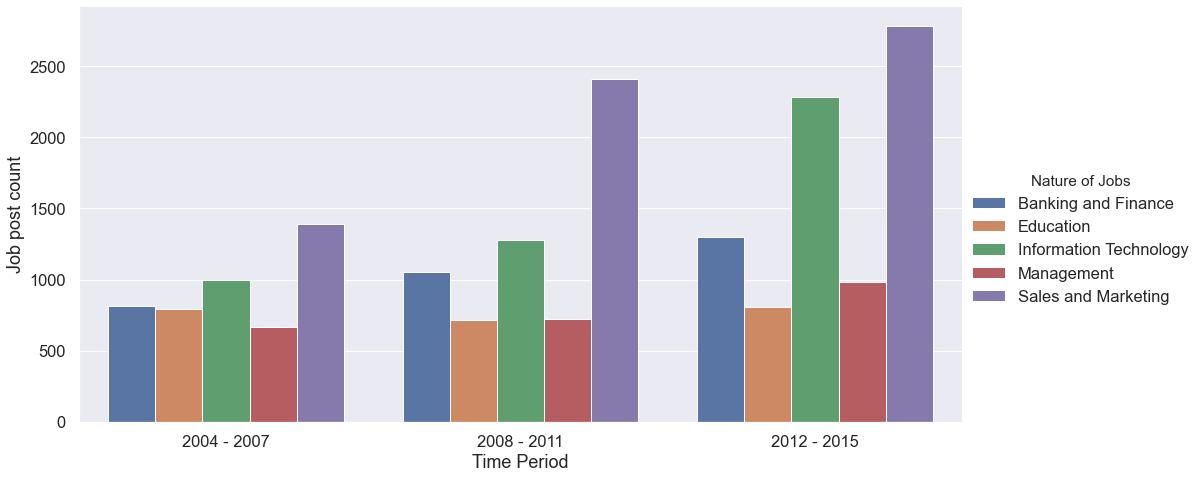

In [883]:
#fig, axs = plt.subplots(figsize = (12,6))
sns.set(font_scale=1.5)
g = sns.catplot(x='Period', y='Dominant_Topic_Name_count', hue='Dominant_Topic_Name',  data=topic_years, kind='bar', height=7, aspect =2, legend_out = True)
g.set_axis_labels("Time Period", "Job post count");
g._legend.set_title('Nature of Jobs')

To understand how the nature of jobs have changed over the years, we filtered out data from 2004 to 2015 in 3 periods of 4 years each against number of job posts, categorizing them in the defined topics (nature of jobs).
As we can see below, all have seen an upward trend over the 3 time periods. Major jump can be seen in sales and marketing requirements between 2004-2007 to 2008-2011. IT saw significant jump from 2008-2011 to 2012-2015.


### Analysing company profiles
1. We would analyze dominant company profiles by doing topic modelling on AboutC column.

In [1034]:
# Convert job requirement to list
aboutC_df = job_data['AboutC'].dropna().reset_index()

In [1035]:
aboutC_Orig_df = aboutC_df.copy()

In [1036]:
aboutC_df.head()

,index,AboutC
0,1,The International Research & Exchanges Board (IREX) is\na US-Based...
1,2,"The Caucasus Environmental NGO Network is a\nnon-governmental, non..."
2,7,The International Research & Exchanges Board (IREX) is\na US-Based...
3,11,The International Research & Exchanges Board (IREX) is\na US-Based...
4,12,"Water User Associations Support Program (WUASP) $25\nmillion, 5 ye..."


In [1037]:
nlp = spacy.load('en_core_web_sm')
matcher = Matcher(nlp.vocab)
matched_sents = [] # collect data of matched sentences to be visualized

#add patterns to the pattern matcher 
pattern = [{'POS':'ADJ'},{'ORTH': '-'}, {'POS':'NOUN', 'OP':'+'}, {'LOWER': 'organization'}]
matcher.add('company has', None, pattern)
pattern = [{'POS':'NOUN', 'OP':'+'}, {'LOWER': 'organization'}]
matcher.add('company has', None, pattern) 
pattern = [{'POS':'NOUN', 'OP':'+'}, {'LOWER': 'company'}]
matcher.add('company has', None, pattern) 
pattern = [{'POS':'NOUN', 'OP':'+'}, {'LOWER': 'services'}]
matcher.add('company has', None, pattern) 
pattern = [{'LOWER': 'company'}, {'POS':'VERB'}, {'POS':'NOUN', 'OP':'+'}]
matcher.add('company has', None, pattern)
pattern = [{'LOWER':'provider'}, {'POS':'ADP'}, {'POS':'NOUN',  'OP': '+'}  , {'POS':'CCONJ','OP':'+'}, {'POS':'NOUN','OP':'+'}]
matcher.add('provider of', None, pattern) 
pattern = [{'LOWER':'provider'}, {'POS':'ADP'}, {'POS':'NOUN',  'OP': '+'}]
matcher.add('provider of', None, pattern) 


In [1038]:
#we would now run all the pattern matching rules on the about company text and extract company profile
for text in aboutC_df.AboutC:
    #removing newlines
    text = re.sub(r'\s+', ' ', text)
    doc = nlp(text)
    #get pattern matches
    matches = matcher(doc)
    row_tokens = []
    #matches would give (match_id, string_id, start, end, span.text)
    #we need text from start and end counters
    for match_id, start, end in matches:
        span = doc[start:end]  # the matched span
        row_tokens.append(span.text)
    matched_sents.append(row_tokens)

In [1039]:
#flattening the 2D array of org types into 1 dimentional 
flat_list = []
for row in matched_sents:
    for token in row:
        flat_list.append(token)

In [1040]:
#converting to series to plot with seaborn
flat_series = pd.Series(flat_list)
flat_series = flat_series.value_counts()
flat_series = (flat_series[:50])
flat_series

development company                          638
software development company                 516
software company                             260
credit organization                          135
development organization                     129
IT company                                   116
consulting services                          108
stock company                                101
investment company                            98
project management software company           74
management software company                   74
advocacy organization                         74
consulting company                            73
profit organization                           68
engineering company                           64
engineering development company               63
construction company                          62
outsourcing services                          58
tech company                                  57
parent company                                57
software engineering

In [1041]:
#reving the below terms as they do not make sense
remove_company = ['development company', 'development organization', 'management software company',
'project management software company','profit organization','parent company','groups parent company',
'development services','company visiting www.attask.com','company delivering bespoke','company delivering bespoke business']

In [1042]:
# Remove terms that are not useful in this context
flat_list = [i for i in flat_list if not (i in remove_company)]
#converting to series to plot with seaborn
flat_series = pd.Series(flat_list)
flat_series = flat_series.value_counts()
flat_series = (flat_series[:50])

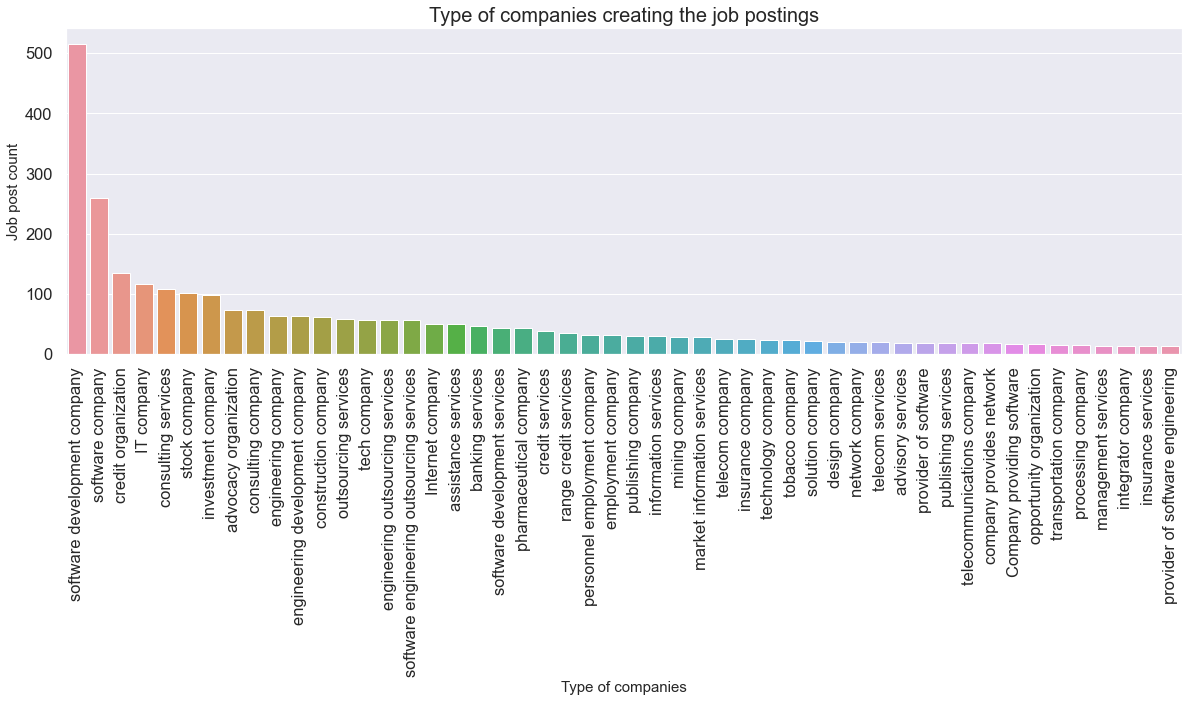

In [1043]:
#Type of companies creating the job postings
sns.set(font_scale=1.5)
fig, axs = plt.subplots(figsize = (20,6))
sns.barplot(flat_series.index, flat_series.values,  orient='v')

plt.title('Type of companies creating the job postings',fontsize=20)
plt.xlabel('Type of companies',fontsize=15)
plt.ylabel('Job post count',fontsize=15)
plt.xticks(rotation=90)
plt.show()

After the initial pass, the output from pattern matching on the AboutC column, we removed the below terms as they were not making sense and were not adding any value to our analysis.
     development company', 'development organization', 'management software company’, 'project management software
     company','profit organization','parent company','groups parent company’, 'development services','company visiting
     www.attask.com','company delivering bespoke','company delivering bespoke business’ <br><br>
We were able to capture the company profiles using the above approach and visualized as a bar plot in the next slide.


### Similarity between job postings
1. Given a job title, find the 5 top jobs that are of similar nature, based on jobpost.
2. Below we a select a random document from the document corpus based on job title and find documents similar to it.
3. The above would imply that if a jobpost and title is provide then we would find top 5 existing similar posts.

We used the TF-IDF cosine similarity technique to assign similarity scores to the job posts in order to find the top 5 similar documents. Higher the similarity score more similar the documents are.
For the purpose of this exercise, we selected a random document from the corpus based on job title and found documents similar to it. This approach would imply that if a jobpost and title is provide from outside of the corpus, we would be able to find top 5 existing similar posts from the corpus.


In [925]:
#get sklearn.feature_extraction.text.TfidfVectorizer
vectorizer = TfidfVectorizer()

In [950]:
#returns cosine similarities with selected corpus and query doc.
def get_tf_idf_query_similarity(vectorizer, docs, query):
    docs_tfidf = vectorizer.fit_transform(docs)
    query_tfidf = vectorizer.transform([query])
    cosineSimilarities = cosine_similarity(query_tfidf, docs_tfidf).flatten()
    return cosineSimilarities

In [951]:
#filter documents based on title
def select_documents(title):
    select_docs = job_data[job_data['Title'] == title]
    chunk_docs = select_docs[['jobpost','clean_job_post','Title']].reset_index()
    return chunk_docs

In [954]:
#select query document randomly
def select_query_doc(chunk_docs):
    randint = np.random.randint(0,(chunk_docs.shape)[0])
    query = chunk_docs['clean_job_post'].loc[randint]
    return query

In [956]:
#get cosine similarities and sort.
def get_similar_docs(chunk_docs, query):
    similarity = get_tf_idf_query_similarity(vectorizer, chunk_docs['clean_job_post'], query)
    chunk_docs['similarity_score'] = similarity
    sorted_chunk_docs = chunk_docs.sort_values(by='similarity_score', ascending=False).reset_index()
    return sorted_chunk_docs


In [957]:
#we would find similar posts for 'Software Developer'
chunk_docs = select_documents('Software Developer')
query = select_query_doc(chunk_docs)
sorted_chunk_docs = get_similar_docs(chunk_docs, query)


In [976]:
#select top 5
#excluding the first document in the frame, as it is the query document and similarity score would be 1
pd.set_option('display.max_colwidth', 70)
sorted_chunk_docs.loc[1:5][['Title','jobpost','clean_job_post','similarity_score']]

,Title,jobpost,clean_job_post,similarity_score
1,Project Coordinator,"""Bridge of Hope"" NGO\nTITLE: Project Coordinator\nDURATION: One ...",bridge hope project coordinator year possible extension bridge hop...,0.487652
2,Project Coordinator,"""Bridge of Hope"" NGO\nTITLE: Project Coordinator\nSTART DATE/ TIM...",bridge hope project coordinator start time february year possible ...,0.333464
3,Project Coordinator,Mission East\nTITLE: Project Coordinator\nTERM: Full time\nOPEN ...,mission east project coordinator term time open eligibility criter...,0.280880
4,Project Coordinator,World Vision Armenia\nTITLE: Project Coordinator\nTERM: Full tim...,world vision project coordinator term time open eligibility criter...,0.265426
5,Project Coordinator,World Vision Armenia\nTITLE: Project Coordinator\nLOCATION: Yere...,world vision project coordinator supervision project manager incum...,0.259138


In [977]:
#we would find similar posts for 'General Manager'
chunk_docs = select_documents('General Manager')
query = select_query_doc(chunk_docs)
sorted_chunk_docs = get_similar_docs(chunk_docs, query)
sorted_chunk_docs.loc[1:5][['Title','jobpost','clean_job_post','similarity_score']]

,Title,jobpost,clean_job_post,similarity_score
1,General Manager,Bav City LLC\nTITLE: General Manager\nOPEN TO/ ELIGIBILITY CRITER...,city general manager open eligibility criterion qualify candidate ...,0.241541
2,General Manager,Made To Make LLC\nTITLE: General Manager\nTERM: Full time\nOPEN ...,general manager term time open eligibility criterion qualify candi...,0.222292
3,General Manager,Telia-Med CJSC\n\n\nTITLE: General Manager\n\n\nTERM: Full-time\...,teliamed cjsc general manager term fulltime start time soon possib...,0.206487
4,General Manager,Pregomesh Jewelry\n\n\nTITLE: General Manager\n\n\nTERM: Full-ti...,pregomesh jewelry general manager term fulltime start time asap lo...,0.203726
5,General Manager,Megafood LLC\nTITLE: General Manager\nTERM: Full time\nSTART DAT...,megafood general manager term time start time asap permanent gener...,0.203612


In [978]:
#we would find similar posts for 'Project Coordinator'
chunk_docs = select_documents('Project Coordinator')
query = select_query_doc(chunk_docs)
sorted_chunk_docs = get_similar_docs(chunk_docs, query)
sorted_chunk_docs.loc[1:5][['Title','jobpost','clean_job_post','similarity_score']]

,Title,jobpost,clean_job_post,similarity_score
1,Project Coordinator,WWF Armenia\nTITLE: Project Coordinator\nTERM: Full time\nOPEN T...,project coordinator term time open eligibility criterion intereste...,0.206063
2,Project Coordinator,EKENG CJSC\nTITLE: Project Coordinator\nTERM: Full time\nOPEN TO...,ekeng cjsc project coordinator term time open eligibility criterio...,0.200418
3,Project Coordinator,Mentor Graphics Development Services CJSC\nTITLE: Project Coordin...,mentor graphic development service cjsc project coordinator term t...,0.196794
4,Project Coordinator,McCann Erickson Armenia\nTITLE: Project Coordinator\nOPEN TO/ ELI...,mccann erickson project coordinator open eligibility criterion int...,0.191433
5,Project Coordinator,National Competitiveness Foundation of Armenia\nTITLE: Project Co...,national competitiveness foundation project coordinator term time ...,0.178832
